In [178]:
#any object with __len__ and __getitem__ can be made to Dataset
import torch
import numpy as np
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [179]:
import glob

In [180]:
all_image_path = glob.glob('./data/weather_pics/*.jpg')

In [181]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [182]:
# Create a projection relationship between class and index
species = ['clou', 'rain', 'shin', 'sunr']

species_to_idx = dict((c, i) for i, c in enumerate(species))
species_to_idx

{'clou': 0, 'rain': 1, 'shin': 2, 'sunr': 3}

In [183]:
#reverse the key and valus
idx_to_species = dict((v, k) for k, v in species_to_idx.items())
idx_to_species

{0: 'clou', 1: 'rain', 2: 'shin', 3: 'sunr'}

In [184]:
#generate lables
all_labels = []
for img in all_image_path:
    for i, c in enumerate(species):
        if c in img:
            all_labels.append(i)        

In [185]:
all_labels[:5]

[0, 1, 1, 0, 3]

In [186]:
# radomize the order of images
index = np.random.permutation(len(all_image_path))

In [187]:
all_image_path = np.array(all_image_path)[index]
all_labels = np.array(all_labels)[index]

## Manually split train/test data

In [188]:
split = int(len(all_image_path)*0.8)

In [189]:
train_imgs = all_image_path[:split]
train_labels = all_labels[:split]

test_imgs = all_image_path[split:]
test_labels = all_labels[split:]

In [190]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor()
])

In [191]:
class MyDataset(torch.utils.data.Dataset):
    def __init__ (self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
    #simulate ImageFolder
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = self.labels[index]

        img = Image.open(img_path)
        if np.array(img).shape[-1] ==3:
            data = self.transforms(img)
            return data, torch.from_numpy(np.array(label)).type(torch.LongTensor)
        else:
            print(img_path)
            return self.__getitem__(index + 1)

    def __len__(self):
        return len(self.imgs)

    #rewrite collate_fn
    @staticmethod
    def collate_fn(batch):
        #batch is a list, length is batch_size
        #every element is a tuple (x,y): [(x1, y1), (x2,y2), (x3,y3)....]
        #filter out the None in batch
        #collate_fn is to put all x together, all y together
        batch = [_ for _ in batch if _ is not None]
        # from torch.utils.data.dataloader import default_collate
        # return default_collate(batch)
        imgs, labels = zip(*batch)
        return torch.stack(imgs, 0), torch.stack(labels, 0)

In [192]:
dataset = MyDataset(all_image_path, all_labels, transform)

In [193]:
len(dataset)

1095

In [194]:
train_ds = dataset = MyDataset(train_imgs, train_labels, transform)
test_ds = dataset = MyDataset(test_imgs, train_labels, transform)

In [195]:
len(test_ds)

219

In [196]:
batch_size = 16
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True, collate_fn = MyDataset.collate_fn, drop_last = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size*2, collate_fn = MyDataset.collate_fn, drop_last = True)
# for x, y in train_dl:
#     print(x.shape, y.shape)

In [197]:
#imgs, labels = 
imgs, labels = next(iter(train_dl))

In [198]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [199]:
labels

tensor([1, 0, 2, 1, 3, 2, 0, 3, 3, 2, 0, 3, 1, 0, 3, 0])

In [200]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) #16, 94, 94
        #batch normalization
        self.bn1 = nn.BatchNorm2d(16) #16 channles
        self.pool = nn.MaxPool2d(2,2) # 16, 47, 47
        self.conv2 = nn.Conv2d(16, 32, 3) #32, 45, 45
        self.bn2 = nn.BatchNorm2d(32) #32 channles
        #another layer of pooling 32, 22, 22
        self.conv3 = nn.Conv2d(32, 64, 3) # 64, 20, 20
        self.bn3 = nn.BatchNorm2d(64) #64 channles
        #another layer of pooling 64, 10, 10
        
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64*10*10, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024) #1024 channles
        self.fc2 = nn.Linear(1024, 256)
        self.bn_fc2 = nn.BatchNorm1d(256) #2564 channles
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)

        x = nn.Flatten()(x)
        # x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [201]:
model = Net()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [202]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [203]:
def fit (epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0

    for x, y in train_loader:
        #put the data to GPU
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim = 1)
            correct += (y_pred==y).sum().item()
            total += y.size(0)
            running_loss +=loss.item()
            
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = correct/total
    
    #test
    test_correct = 0
    test_running_loss = 0
    test_total = 0

    with torch.no_grad():
        for x, y in test_loader:
            #put the data to GPU
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim = 1)
            test_correct += (y_pred==y).sum().item()
            test_total += y.size(0)
            test_running_loss +=loss.item()
    
    test_epoch_loss = test_running_loss/len(test_loader.dataset)
    test_epoch_acc = test_correct/test_total

    print(f'Epoch: {epoch}, loss:{round(epoch_loss, 3)}, accuracy: {round(epoch_acc, 3)}, test_loss: {round(test_epoch_loss, 3)}, test_accuracy: {round(test_epoch_acc, 3)}')
    
    return  epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc  
                

In [204]:
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

./data/weather_pics/shine127.jpg
./data/weather_pics/cloudy66.jpg
./data/weather_pics/rain141.jpg
./data/weather_pics/cloudy71.jpg
./data/weather_pics/shine131.jpg
Epoch: 0, loss:0.042, accuracy: 0.751, test_loss: 0.099, test_accuracy: 0.25
./data/weather_pics/shine127.jpg
./data/weather_pics/rain141.jpg
./data/weather_pics/cloudy71.jpg
./data/weather_pics/cloudy66.jpg
./data/weather_pics/shine131.jpg
Epoch: 1, loss:0.027, accuracy: 0.848, test_loss: 0.099, test_accuracy: 0.234
./data/weather_pics/rain141.jpg
./data/weather_pics/cloudy71.jpg
./data/weather_pics/cloudy66.jpg
./data/weather_pics/shine127.jpg
./data/weather_pics/shine131.jpg
Epoch: 2, loss:0.022, accuracy: 0.869, test_loss: 0.107, test_accuracy: 0.219
./data/weather_pics/shine127.jpg
./data/weather_pics/cloudy66.jpg
./data/weather_pics/rain141.jpg
./data/weather_pics/cloudy71.jpg
./data/weather_pics/shine131.jpg
Epoch: 3, loss:0.017, accuracy: 0.903, test_loss: 0.131, test_accuracy: 0.229
./data/weather_pics/cloudy66.jpg


In [209]:
all_labels.dtype

dtype('int64')

In [213]:
bad_img = Image.open('./data/weather_pics/cloudy66.jpg')

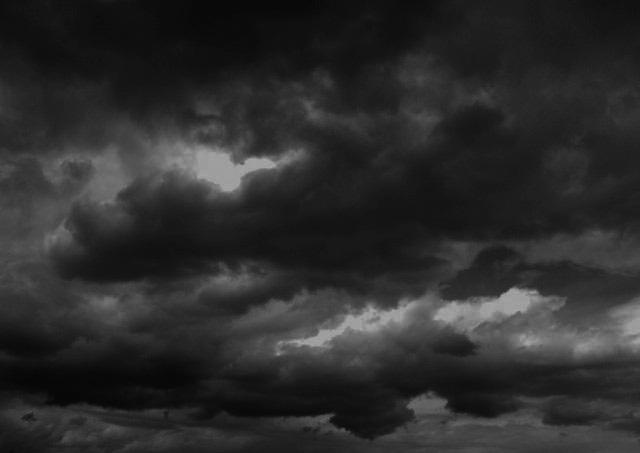

In [214]:
bad_img

In [215]:
np.asarray(bad_img)

array([[14, 15, 15, ..., 17, 16, 16],
       [14, 15, 15, ..., 17, 17, 16],
       [15, 15, 15, ..., 17, 17, 16],
       ...,
       [19, 16, 17, ..., 65, 65, 65],
       [17, 14, 17, ..., 67, 67, 67],
       [17, 14, 17, ..., 67, 67, 67]], shape=(453, 640), dtype=uint8)